# ANLY 590 - Automatic Scoring with Neural Bag of Words (Run on Colab)

### Data Description

The data is obtained from the Automated Student Assessment Prize (ASAP) AES dataset (https://www.kaggle.com/c/asap-aes/data), which contains essays written by students ranging from Grade 7 to Grade 10. The dataset consists of 8 essay sets, each with a different topic or prompt, with a total of 12,978 essays with scores.

Each of the sets of essays was generated from a single prompt. Selected essays range from an average length of 150 to 550 words per response. Some of the essays are dependent upon source information and others are not. All responses were written by students ranging in grade levels from Grade 7 to Grade 10. All essays were hand graded and were double-scored. Each of the eight data sets has its own unique characteristics. The variability is intended to test the limits of your scoring engine's capabilities.

The training data is provided in three formats: a tab-separated value (TSV) file, a Microsoft Excel 2010 spreadsheet, and a Microsoft Excel 2003 spreadsheet.  The current release of the training data contains essay sets 1-6.  Sets 7-8 will be released on February 10, 2012.  Each of these files contains 28 columns:

    essay_id: A unique identifier for each individual student essay
    essay_set: 1-8, an id for each set of essays
    essay: The ascii text of a student's response
    rater1_domain1: Rater 1's domain 1 score; all essays have this
    rater2_domain1: Rater 2's domain 1 score; all essays have this
    rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
    domain1_score: Resolved score between the raters; all essays have this
    rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
    rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
    domain2_score: Resolved score between the raters; only essays in set 2 have this
    rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8


### Setting up ML libraries

Importing the relevant NLP and tensorflow libraries for our use.

In [0]:
#!pip install constants

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json, os, re, shutil, sys, time
from importlib import reload
import collections, itertools
import unittest
from IPython.display import display, HTML

import datetime
from timeit import default_timer as timer
from datetime import timedelta

# NLTK for NLP utils and corpora
import nltk
nltk.download('punkt')
import string

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# Pandas and SKLearn
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#!pip install kashgari
# Utilizing a package Kashgari to perform the pre-trained BERT embeddings
from kashgari.embeddings import BERTEmbedding

!pip install layers
# Importing Keras packages
from keras import initializers, regularizers, optimizers
from keras.layers import LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
# import layers; reload(layers)
# from layers import AttentionWithContext, Addition

# Importing packages for Tensorboard for Keras
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

# XGBoost
import xgboost
from xgboost.sklearn import XGBRegressor

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# **Layers:**

In [0]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from keras.optimizers import Adam
from keras import initializers, regularizers
from keras import optimizers
from keras.engine.topology import Layer
from keras import constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    follows these equations:

    (1) u_t = tanh(W h_t + b)
    (2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
    (3) v_t = \alpha_t * h_t, v in time t
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        3D tensor with shape: `(samples, steps, features)`.
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's. 
        # Should add a small epsilon as the workaround
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]
    
class Addition(Layer):
    """
    This layer is supposed to add of all activation weight.
    We split this from AttentionWithContext to help us getting the activation weights
    follows this equation:
    (1) v = \sum_t(\alpha_t * h_t)

    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[-1]
        super(Addition, self).build(input_shape)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# patched_numpy_io

In [0]:
# Modified from tensorflow/python/estimator/inputs/numpy_io.py

# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Methods to allow dict of numpy arrays."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
from tensorflow.python.estimator.inputs.queues import feeding_functions

# Key name to pack the target into dict of `features`. See
# `_get_unique_target_key` for details.
_TARGET_KEY = '__target_key__'


def _get_unique_target_key(features):
  """Returns a key not existed in the input dict `features`.
  Caller of `input_fn` usually provides `features` (dict of numpy arrays) and
  `target`, but the underlying feeding module expects a single dict of numpy
  arrays as input. So, the `target` needs to be packed into the `features`
  temporarily and unpacked after calling the feeding function. Toward this goal,
  this function returns a key not existed in the `features` to pack the
  `target`.
  """
  target_key = _TARGET_KEY
  while target_key in features:
    target_key += '_n'
  return target_key


def numpy_input_fn(x,
                   y=None,
                   batch_size=128,
                   num_epochs=1,
                   shuffle=None,
				   seed=42,
                   queue_capacity=1000,
                   num_threads=1):
  """Returns input function that would feed dict of numpy arrays into the model.
  This returns a function outputting `features` and `target` based on the dict
  of numpy arrays. The dict `features` has the same keys as the `x`.
  Example:
  ```python
  age = np.arange(4) * 1.0
  height = np.arange(32, 36)
  x = {'age': age, 'height': height}
  y = np.arange(-32, -28)
  with tf.Session() as session:
    input_fn = numpy_io.numpy_input_fn(
        x, y, batch_size=2, shuffle=False, num_epochs=1)
  ```
  Args:
    x: dict of numpy array object.
    y: numpy array object. `None` if absent.
    batch_size: Integer, size of batches to return.
    num_epochs: Integer, number of epochs to iterate over data. If `None` will
      run forever.
    shuffle: Boolean, if True shuffles the queue. Avoid shuffle at prediction
      time.
	seed: seed for RNG, to use if shuffle=True.
    queue_capacity: Integer, size of queue to accumulate.
    num_threads: Integer, number of threads used for reading and enqueueing. In
      order to have predicted and repeatable order of reading and enqueueing,
      such as in prediction and evaluation mode, `num_threads` should be 1.
  Returns:
    Function, that has signature of ()->(dict of `features`, `target`)
  Raises:
    ValueError: if the shape of `y` mismatches the shape of values in `x` (i.e.,
      values in `x` have same shape).
    TypeError: `x` is not a dict or `shuffle` is not bool.
  """

  if not isinstance(shuffle, bool):
    raise TypeError('shuffle must be explicitly set as boolean; '
                    'got {}'.format(shuffle))

  def input_fn():
    """Numpy input function."""
    if not isinstance(x, dict):
      raise TypeError('x must be dict; got {}'.format(type(x).__name__))

    # Make a shadow copy and also ensure the order of iteration is consistent.
    ordered_dict_x = collections.OrderedDict(
        sorted(x.items(), key=lambda t: t[0]))

    unique_target_key = _get_unique_target_key(ordered_dict_x)
    if y is not None:
      ordered_dict_x[unique_target_key] = y

    if len(set(v.shape[0] for v in ordered_dict_x.values())) != 1:
      shape_dict_of_x = {k: ordered_dict_x[k].shape
                         for k in ordered_dict_x.keys()}
      shape_of_y = None if y is None else y.shape
      raise ValueError('Length of tensors in x and y is mismatched. All '
                       'elements in x and y must have the same length.\n'
                       'Shapes in x: {}\n'
                       'Shape for y: {}\n'.format(shape_dict_of_x, shape_of_y))

    queue = feeding_functions._enqueue_data(  # pylint: disable=protected-access
        ordered_dict_x,
        queue_capacity,
        shuffle=shuffle,
		seed=seed,
        num_threads=num_threads,
        enqueue_size=batch_size,
        num_epochs=num_epochs)

    features = (queue.dequeue_many(batch_size) if num_epochs is None
                else queue.dequeue_up_to(batch_size))

    # Remove the first `Tensor` in `features`, which is the row number.
    if len(features) > 0:
      features.pop(0)

    features = dict(zip(ordered_dict_x.keys(), features))
    if y is not None:
      target = features.pop(unique_target_key)
      return features, target
    return features

  return input_fn


# utils

In [0]:
from __future__ import print_function
from __future__ import division

import re
import time
import itertools
import numpy as np

# For pretty-printing
import pandas as pd
from IPython.display import display, HTML

#from . import constants
import constants

##
# Package and module utils
def require_package(package_name):
    import pkgutil
    import subprocess
    import sys
    if not pkgutil.find_loader(package_name):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

def run_tests(test_module, test_names, reload=True):
    import unittest
    if reload:
        import importlib
        importlib.reload(test_module)
    unittest.TextTestRunner(verbosity=2).run(
        unittest.TestLoader().loadTestsFromNames(
            test_names, test_module))

##
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))

def render_matrix(M, rows=None, cols=None, dtype=float, float_fmt="{0:.04f}"):
    """Render a matrix to HTML using Pandas.

    Args:
      M : 2D numpy array
      rows : list of row labels
      cols : list of column labels
      dtype : data type (float or int)
      float_fmt : format specifier for floats

    Returns:
      (string) HTML representation of M
    """
    df = pd.DataFrame(M, index=rows, columns=cols, dtype=dtype)
    old_fmt_fn = pd.get_option('float_format')
    pd.set_option('float_format', lambda f: float_fmt.format(f))
    html = df._repr_html_()
    pd.set_option('float_format', old_fmt_fn)  # reset Pandas formatting
    return html

def pretty_print_matrix(*args, **kw):
    """Pretty-print a matrix using Pandas.

    Args:
      M : 2D numpy array
      rows : list of row labels
      cols : list of column labels
      dtype : data type (float or int)
      float_fmt : format specifier for floats
    """
    display(HTML(render_matrix(*args, **kw)))


def pretty_timedelta(fmt="%d:%02d:%02d", since=None, until=None):
    """Pretty-print a timedelta, using the given format string."""
    since = since or time.time()
    until = until or time.time()
    delta_s = until - since
    hours, remainder = divmod(delta_s, 3600)
    minutes, seconds = divmod(remainder, 60)
    return fmt % (hours, minutes, seconds)


##
# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

##
# Data loading functions
def get_corpus(name):
    import nltk
    assert(nltk.download(name))
    return nltk.corpus.__getattr__(name)

def build_vocab(corpus, V=10000, **kw):
    from . import vocabulary
    if isinstance(corpus, list):
        token_feed = (canonicalize_word(w) for w in corpus)
        vocab = vocabulary.Vocabulary(token_feed, size=V, **kw)
    else:
        token_feed = (canonicalize_word(w) for w in corpus.words())
        vocab = vocabulary.Vocabulary(token_feed, size=V, **kw)

    print("Vocabulary: {:,} types".format(vocab.size))
    return vocab

def get_train_test_sents(corpus, split=0.8, shuffle=True):
    """Generate train/test split for unsupervised tasks.

    Args:
      corpus: nltk.corpus that supports sents() function
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.

    Returns:
      train_sentences, test_sentences ( list(list(string)) ): the train and test
      splits
    """
    sentences = np.array(list(corpus.sents()), dtype=object)
    fmt = (len(sentences), sum(map(len, sentences)))
    print("Loaded {:,} sentences ({:g} tokens)".format(*fmt))

    if shuffle:
        rng = np.random.RandomState(shuffle)
        rng.shuffle(sentences)  # in-place
    split_idx = int(split * len(sentences))
    train_sentences = sentences[:split_idx]
    test_sentences = sentences[split_idx:]

    fmt = (len(train_sentences), sum(map(len, train_sentences)))
    print("Training set: {:,} sentences ({:,} tokens)".format(*fmt))
    fmt = (len(test_sentences), sum(map(len, test_sentences)))
    print("Test set: {:,} sentences ({:,} tokens)".format(*fmt))

    return train_sentences, test_sentences

def preprocess_sentences(sentences, vocab, use_eos=False, emit_ids=True,
                         progressbar=lambda l:l):
    """Preprocess sentences by canonicalizing and mapping to ids.

    Args:
      sentences ( list(list(string)) ): input sentences
      vocab: Vocabulary object, already initialized
      use_eos: if true, will add </s> token to end of sentence.
      emit_ids: if true, will emit as ids. Otherwise, will be preprocessed
          tokens.
      progressbar: (optional) progress bar to wrap iterator.

    Returns:
      ids ( array(int) ): flattened array of sentences, including boundary <s>
      tokens.
    """
    # Add sentence boundaries, canonicalize, and handle unknowns
    word_preproc = lambda w: canonicalize_word(w, wordset=vocab.word_to_id)
    ret = []
    for s in progressbar(sentences):
        canonical_words = vocab.pad_sentence(list(map(word_preproc, s)),
                                             use_eos=use_eos)
        ret.extend(vocab.words_to_ids(canonical_words) if emit_ids else
                   canonical_words)
    if not use_eos:  # add additional <s> to end if needed
        ret.append(vocab.START_ID if emit_ids else vocab.START_TOKEN)
    return np.array(ret, dtype=(np.int32 if emit_ids else object))


def load_corpus(corpus, split=0.8, V=10000, shuffle=0):
    """Load a named corpus and split train/test along sentences.

    This is a convenience wrapper to chain together several functions from this
    module, and produce a train/test split suitable for input to most models.

    Sentences are preprocessed by canonicalization and converted to ids
    according to the constructed vocabulary, and interspersed with <s> tokens
    to denote sentence bounaries.

    Args:
        corpus: (string | corpus reader) If a string, will fetch the
            NLTK corpus of that name.
        split: (float \in (0,1]) fraction of examples in train split
        V: (int) vocabulary size (including special tokens)
        shuffle: (int) if > 0, use as random seed to shuffle sentence prior to
            split. Can change this to get different splits.

    Returns:
        (vocab, train_ids, test_ids)
        vocab: vocabulary.Vocabulary object
        train_ids: flat (1D) np.array(int) of ids
        test_ids: flat (1D) np.array(int) of ids
    """
    if isinstance(corpus, str):
        corpus = get_corpus(corpus)
    vocab = build_vocab(corpus, V)
    train_sentences, test_sentences = get_train_test_sents(corpus, split, shuffle)
    train_ids = preprocess_sentences(train_sentences, vocab)
    test_ids = preprocess_sentences(test_sentences, vocab)
    return vocab, train_ids, test_ids

##
# Window and batch functions
def pad_np_array(example_ids, max_len=250, pad_id=0):
    """Pad a list of lists of ids into a rectangular NumPy array.

    Longer sequences will be truncated to max_len ids, while shorter ones will
    be padded with pad_id.

    Args:
        example_ids: list(list(int)), sequence of ids for each example
        max_len: maximum sequence length
        pad_id: id to pad shorter sequences with

    Returns: (x, ns)
        x: [num_examples, max_len] NumPy array of integer ids
        ns: [num_examples] NumPy array of sequence lengths (<= max_len)
    """
    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr, ns

def id_lists_to_sparse_bow(id_lists, vocab_size):
    """Convert a list-of-lists-of-ids to a sparse bag-of-words matrix.

    Args:
        id_lists: (list(list(int))) list of lists of word ids
        vocab_size: (int) vocab size; must be greater than the largest word id
            in id_lists.

    Returns:
        (scipy.sparse.csr_matrix) where each row is a sparse vector of word
        counts for the corresponding example.
    """
    from scipy import sparse
    ii = []  # row indices (example ids)
    jj = []  # column indices (token ids)
    for row_id, ids in enumerate(id_lists):
        ii.extend([row_id]*len(ids))
        jj.extend(ids)
    x = sparse.csr_matrix((np.ones_like(ii), (ii, jj)),
                          shape=[len(id_lists), vocab_size])
    return x

def rnnlm_batch_generator(ids, batch_size, max_time):
    """Convert ids to data-matrix form for RNN language modeling."""
    # Clip to multiple of max_time for convenience
    clip_len = ((len(ids)-1) // batch_size) * batch_size
    input_w = ids[:clip_len]     # current word
    target_y = ids[1:clip_len+1]  # next word
    # Reshape so we can select columns
    input_w = input_w.reshape([batch_size,-1])
    target_y = target_y.reshape([batch_size,-1])

    # Yield batches
    for i in range(0, input_w.shape[1], max_time):
        yield input_w[:,i:i+max_time], target_y[:,i:i+max_time]


def build_windows(ids, N, shuffle=True):
    """Build window input to the window model.

    Takes a sequence of ids, and returns a data matrix where each row
    is a window and target for the window model. For N=3:
        windows[i] = [w_3, w_2, w_1, w_0]

    For language modeling, N is the context size and you can use y = windows[:,-1]
    as the target words and x = windows[:,:-1] as the contexts.

    For CBOW, N is the window size and you can use y = windows[:,N/2] as the target words
    and x = np.hstack([windows[:,:N/2], windows[:,:N/2+1]]) as the contexts.

    For skip-gram, you can use x = windows[:,N/2] as the input words and y = windows[:,i]
    where i != N/2 as the target words.

    Args:
      ids: np.array(int32) of input ids
      shuffle: if true, will randomly shuffle the rows

    Returns:
      windows: np.array(int32) of shape [len(ids)-N, N+1]
        i.e. each row is a window, of length N+1
    """
    windows = np.zeros((len(ids)-N, N+1), dtype=int)
    for i in range(N+1):
        # First column: first word, etc.
        windows[:,i] = ids[i:len(ids)-(N-i)]
    if shuffle:
        # Shuffle rows
        np.random.shuffle(windows)
    return windows


def batch_generator(data, batch_size):
    """Generate minibatches from data.

    Args:
      data: array-like, supporting slicing along first dimension
      batch_size: int, batch size

    Yields:
      minibatches of maximum size batch_size
    """
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

def multi_batch_generator(batch_size, *data_arrays):
    """Generate minibatches from multiple columns of data.

    Example:
        for (bx, by) in multi_batch_generator(5, x, y):
            # bx is minibatch for x
            # by is minibatch for y

    Args:
      batch_size: int, batch size
      data_arrays: one or more array-like, supporting slicing along the first
        dimension, and with matching first dimension.

    Yields:
      minibatches of maximum size batch_size
    """
    assert(data_arrays)
    num_examples = len(data_arrays[0])
    for i in range(1, len(data_arrays)):
        assert(len(data_arrays[i]) == num_examples)

    for i in range(0, num_examples, batch_size):
        # Yield matching slices from each data array.
        yield tuple(data[i:i+batch_size] for data in data_arrays)


### Loading in the data

Data from AES dataset is stored in the `/data/` folder.  We will begin by loading the training dataset `training_set_rel3.tsv` and partitioning it into train, test split.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/590project/data/training_set_rel3.cav.csv"

'/content/drive/My Drive/Colab Notebooks/590project/data/training_set_rel3.cav.csv'


In [0]:
training_set_rel3_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/590project/data/training_set_rel3.cav.csv")
#training_set_rel3_df.head()
print("No. of rows in full data set:", len(training_set_rel3_df))

No. of rows in full data set: 12978


In [0]:
training_set_rel3_df.head(3)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Dropping data with no scores in "domain1_score"
training_set_rel3_df.dropna(axis=0, subset=['domain1_score'], inplace=True)
print("No. of rows in full data set:", len(training_set_rel3_df))

No. of rows in full data set: 12977


In [0]:
# Setting up the prompts
prompt_dict = {1 : 'More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.',
               2 : 'Censorship in the Libraries. "All of us can think of a book that we hope none of our children or any other children have taken off the shelf. But if I have the right to remove that book from the shelf -- that work I abhor -- then you also have exactly the same right and so does everyone else. And then we have no books left on the shelf for any of us." --Katherine Paterson, Author. Write a persuasive essay to a newspaper reflecting your views on censorship in libraries. Do you believe that certain materials, such as books, music, movies, magazines, etc., should be removed from the shelves if they are found offensive? Support your position with convincing arguments from your own experience, observations, and/or reading.',
               3 : 'ROUGH ROAD AHEAD: Do Not Exceed Posted Speed Limit -- by Joe Kurmaskie. FORGET THAT OLD SAYING ABOUT NEVER taking candy from strangers. No, a better piece of advice for the solo cyclist would be, “Never accept travel advice from a collection of old-timers who haven’t left the confines of their porches since Carter was in office.” It’s not that a group of old guys doesn’t know the terrain. With age comes wisdom and all that, but the world is a fluid place. Things change. At a reservoir campground outside of Lodi, California, I enjoyed the serenity of an early-summer evening and some lively conversation with these old codgers. What I shouldn’t have done was let them have a peek at my map. Like a foolish youth, the next morning I followed their advice and launched out at first light along a “shortcut” that was to slice away hours from my ride to Yosemite National Park. They’d sounded so sure of themselves when pointing out landmarks and spouting off towns I would come to along this breezy jaunt. Things began well enough. I rode into the morning with strong legs and a smile on my face. About forty miles into the pedal, I arrived at the first “town.” This place might have been a thriving little spot at one time—say, before the last world war—but on that morning it fit the traditional definition of a ghost town. I chuckled, checked my water supply, and moved on. The sun was beginning to beat down, but I barely noticed it. The cool pines and rushing rivers of Yosemite had my name written all over them. Twenty miles up the road, I came to a fork of sorts. One ramshackle shed, several rusty pumps, and a corral that couldn’t hold in the lamest mule greeted me. This sight was troubling. I had been hitting my water bottles pretty regularly, and I was traveling through the high deserts of California in June. I got down on my hands and knees, working the handle of the rusted water pump with all my strength. A tarlike substance oozed out, followed by brackish water feeling somewhere in the neighborhood of two hundred degrees. I pumped that handle for several minutes, but the water wouldn’t cool down. It didn’t matter. When I tried a drop or two, it had the flavor of battery acid. The old guys had sworn the next town was only eighteen miles down the road. I could make that! I would conserve my water and go inward for an hour or so—a test of my inner spirit. Not two miles into this next section of the ride, I noticed the terrain changing. Flat road was replaced by short, rolling hills. After I had crested the first few of these, a large highway sign jumped out at me. It read: ROUGH ROAD AHEAD: DO NOT EXCEED POSTED SPEED LIMIT. The speed limit was 55 mph. I was doing a water-depleting 12 mph. Sometimes life can feel so cruel. I toiled on. At some point, tumbleweeds crossed my path and a ridiculously large snake—it really did look like a diamondback—blocked the majority of the pavement in front of me. I eased past, trying to keep my balance in my dehydrated state. The water bottles contained only a few tantalizing sips. Wide rings of dried sweat circled my shirt, and the growing realization that I could drop from heatstroke on a gorgeous day in June simply because I listened to some gentlemen who hadn’t been off their porch in decades, caused me to laugh. It was a sad, hopeless laugh, mind you, but at least I still had the energy to feel sorry for myself. There was no one in sight, not a building, car, or structure of any kind. I began breaking the ride down into distances I could see on the horizon, telling myself that if I could make it that far, I’d be fine. Over one long, crippling hill, a building came into view. I wiped the sweat from my eyes to make sure it wasn’t a mirage, and tried not to get too excited. With what I believed was my last burst of energy, I maneuvered down the hill. In an ironic twist that should please all sadists reading this, the building—abandoned years earlier, by the looks of it—had been a Welch’s Grape Juice factory and bottling plant. A sandblasted picture of a young boy pouring a refreshing glass of juice into his mouth could still be seen. I hung my head. That smoky blues tune “Summertime” rattled around in the dry honeycombs of my deteriorating brain. I got back on the bike, but not before I gathered up a few pebbles and stuck them in my mouth. I’d read once that sucking on stones helps take your mind off thirst by allowing what spit you have left to circulate. With any luck I’d hit a bump and lodge one in my throat. It didn’t really matter. I was going to die and the birds would pick me clean, leaving only some expensive outdoor gear and a diary with the last entry in praise of old men, their wisdom, and their keen sense of direction. I made a mental note to change that paragraph if it looked like I was going to lose consciousness for the last time. Somehow, I climbed away from the abandoned factory of juices and dreams, slowly gaining elevation while losing hope. Then, as easily as rounding a bend, my troubles, thirst, and fear were all behind me. GARY AND WILBER’S FISH CAMP—IF YOU WANT BAIT FOR THE BIG ONES, WE’RE YOUR BEST BET! “And the only bet,” I remember thinking. As I stumbled into a rather modern bathroom and drank deeply from the sink, I had an overwhelming urge to seek out Gary and Wilber, kiss them, and buy some bait—any bait, even though I didn’t own a rod or reel. An old guy sitting in a chair under some shade nodded in my direction. Cool water dripped from my head as I slumped against the wall beside him. “Where you headed in such a hurry?” “Yosemite,” I whispered. “Know the best way to get there?” I watched him from the corner of my eye for a long moment. He was even older than the group I’d listened to in Lodi. “Yes, sir! I own a very good map.” And I promised myself right then that I’d always stick to it in the future. “Rough Road Ahead” by Joe Kurmaskie, from Metal Cowboy, copyright © 1999 Joe Kurmaskie. Write a response that explains how the features of the setting affect the cyclist. In your response, include examples from the essay that support your conclusion.',
               4 : 'Winter Hibiscus by Minfong Ho Saeng, a teenage girl, and her family have moved to the United States from Vietnam. As Saeng walks home after failing her driver’s test, she sees a familiar plant. Later, she goes to a florist shop to see if the plant can be purchased. It was like walking into another world. A hot, moist world exploding with greenery. Huge flat leaves, delicate wisps of tendrils, ferns and fronds and vines of all shades and shapes grew in seemingly random profusion. “Over there, in the corner, the hibiscus. Is that what you mean?” The florist pointed at a leafy potted plant by the corner. There, in a shaft of the wan afternoon sunlight, was a single blood-red blossom, its five petals splayed back to reveal a long stamen tipped with yellow pollen. Saeng felt a shock of recognition so intense, it was almost visceral. “Saebba,” Saeng whispered. A saebba hedge, tall and lush, had surrounded their garden, its lush green leaves dotted with vermilion flowers. And sometimes after a monsoon rain, a blossom or two would have blown into the well, so that when she drew the well water, she would find a red blossom floating in the bucket. Slowly, Saeng walked down the narrow aisle toward the hibiscus. Orchids, lanna bushes, oleanders, elephant ear begonias, and bougainvillea vines surrounded her. Plants that she had not even realized she had known but had forgotten drew her back into her childhood world. When she got to the hibiscus, she reached out and touched a petal gently. It felt smooth and cool, with a hint of velvet toward the center—just as she had known it would feel. And beside it was yet another old friend, a small shrub with waxy leaves and dainty flowers with purplish petals and white centers. “Madagascar periwinkle,” its tag announced. How strange to see it in a pot, Saeng thought. Back home it just grew wild, jutting out from the cracks in brick walls or between tiled roofs. And that rich, sweet scent—that was familiar, too. Saeng scanned the greenery around her and found a tall, gangly plant with exquisite little white blossoms on it.  “Dok Malik,” she said, savoring the feel of the word on her tongue, even as she silently noted the English name on its tag, “jasmine.” One of the blossoms had fallen off, and carefully Saeng picked it up and smelled it. She closed her eyes and breathed in, deeply. The familiar fragrance filled her lungs, and Saeng could almost feel the light strands of her grandmother’s long gray hair, freshly washed, as she combed it out with the fine-toothed buffalo-horn comb. And when the sun had dried it, Saeng would help the gnarled old fingers knot the hair into a bun, then slip a dok Malik bud into it. Saeng looked at the white bud in her hand now, small and fragile. Gently, she closed her palm around it and held it tight. That, at least, she could hold on to. But where was the fine-toothed comb? The hibiscus hedge? The well? Her gentle grandmother? A wave of loss so deep and strong that it stung Saeng’s eyes now swept over her. A blink, a channel switch, a boat ride into the night, and it was all gone. Irretrievably, irrevocably gone. And in the warm moist shelter of the greenhouse, Saeng broke down and wept. It was already dusk when Saeng reached home. The wind was blowing harder, tearing off the last remnants of green in the chicory weeds that were growing out of the cracks in the sidewalk. As if oblivious to the cold, her mother was still out in the vegetable garden, digging up the last of the onions with a rusty trowel. She did not see Saeng until the girl had quietly knelt down next to her. Her smile of welcome warmed Saeng. “Ghup ma laio le? You’re back?” she said cheerfully. “Goodness, it’s past five. What took you so long? How did it go? Did you—?” Then she noticed the potted plant that Saeng was holding, its leaves quivering in the wind. Mrs. Panouvong uttered a small cry of surprise and delight. “Dok faeng-noi!” she said. “Where did you get it?” “I bought it,” Saeng answered, dreading her mother’s next question. “How much?” For answer Saeng handed her mother some coins. “That’s all?” Mrs. Panouvong said, appalled, “Oh, but I forgot! You and the Lambert boy ate Bee-Maags . . . .” “No, we didn’t, Mother,” Saeng said. “Then what else—?” “Nothing else. I paid over nineteen dollars for it.” “You what?” Her mother stared at her incredulously. “But how could you? All the seeds for this vegetable garden didn’t cost that much! You know how much we—” She paused, as she noticed the tearstains on her daughter’s cheeks and her puffy eyes. “What happened?” she asked, more gently. “I—I failed the test,” Saeng said. For a long moment Mrs. Panouvong said nothing. Saeng did not dare look her mother in the eye. Instead, she stared at the hibiscus plant and nervously tore off a leaf, shredding it to bits. Her mother reached out and brushed the fragments of green off Saeng’s hands. “It’s a beautiful plant, this dok faeng-noi,” she finally said. “I’m glad you got it.” “It’s—it’s not a real one,” Saeng mumbled. “I mean, not like the kind we had at—at—” She found that she was still too shaky to say the words at home, lest she burst into tears again. “Not like the kind we had before,” she said. “I know,” her mother said quietly. “I’ve seen this kind blooming along the lake. Its flowers aren’t as pretty, but it’s strong enough to make it through the cold months here, this winter hibiscus. That’s what matters.” She tipped the pot and deftly eased the ball of soil out, balancing the rest of the plant in her other hand. “Look how root-bound it is, poor thing,” she said. “Let’s plant it, right now.” She went over to the corner of the vegetable patch and started to dig a hole in the ground. The soil was cold and hard, and she had trouble thrusting the shovel into it. Wisps of her gray hair trailed out in the breeze, and her slight frown deepened the wrinkles around her eyes. There was a frail, wiry beauty to her that touched Saeng deeply. “Here, let me help, Mother,” she offered, getting up and taking the shovel away from her. Mrs. Panouvong made no resistance. “I’ll bring in the hot peppers and bitter melons, then, and start dinner. How would you like an omelet with slices of the bitter melon?” “I’d love it,” Saeng said. Left alone in the garden, Saeng dug out a hole and carefully lowered the “winter hibiscus” into it. She could hear the sounds of cooking from the kitchen now, the beating of eggs against a bowl, the sizzle of hot oil in the pan. The pungent smell of bitter melon wafted out, and Saeng’s mouth watered. It was a cultivated taste, she had discovered—none of her classmates or friends, not even Mrs. Lambert, liked it—this sharp, bitter melon that left a golden aftertaste on the tongue. But she had grown up eating it and, she admitted to herself, much preferred it to a Big Mac. The “winter hibiscus” was in the ground now, and Saeng tamped down the soil around it. Overhead, a flock of Canada geese flew by, their faint honks clear and—yes—familiar to Saeng now. Almost reluctantly, she realized that many of the things that she had thought of as strange before had become, through the quiet repetition of season upon season, almost familiar to her now. Like the geese. She lifted her head and watched as their distinctive V was etched against the evening sky, slowly fading into the distance. When they come back, Saeng vowed silently to herself, in the spring, when the snows melt and the geese return and this hibiscus is budding, then I will take that test again. “Winter Hibiscus” by Minfong Ho, copyright © 1993 by Minfong Ho, from Join In, Multiethnic Short Stories, by Donald R. Gallo, ed. Read the last paragraph of the story. "When they come back, Saeng vowed silently to herself, in the spring, when the snows melt and the geese return and this hibiscus is budding, then I will take that test again." Write a response that explains why the author concludes the story with this paragraph. In your response, include details and examples from the story that support your ideas.',
               5 : 'Narciso Rodriguez from Home: The Blueprints of Our Lives My parents, originally from Cuba, arrived in the United States in 1956. After living for a year in a furnished one-room apartment, twenty-one-year-old Rawedia Maria and twenty-seven-year-old Narciso Rodriguez, Sr., could afford to move into a modest, three-room apartment I would soon call home. In 1961, I was born into this simple house, situated in a two-family, blond-brick building in the Ironbound section of Newark, New Jersey. Within its walls, my young parents created our traditional Cuban home, the very heart of which was the kitchen. My parents both shared cooking duties and unwittingly passed on to me their rich culinary skills and a love of cooking that is still with me today (and for which I am eternally grateful). Passionate Cuban music (which I adore to this day) filled the air, mixing with the aromas of the kitchen. Here, the innocence of childhood, the congregation of family and friends, and endless celebrations that encompassed both, formed the backdrop to life in our warm home. Growing up in this environment instilled in me a great sense that “family” had nothing to do with being a blood relative. Quite the contrary, our neighborhood was made up of mostly Spanish, Cuban, and Italian immigrants at a time when overt racism was the norm and segregation prevailed in the United States. In our neighborhood, despite customs elsewhere, all of these cultures came together in great solidarity and friendship. It was a close-knit community of honest, hardworking immigrants who extended a hand to people who, while not necessarily their own kind, were clearly in need. Our landlord and his daughter, Alegria (my babysitter and first friend), lived above us, and Alegria graced our kitchen table for meals more often than not. Also at the table were Sergio and Edelmira, my surrogate grandparents who lived in the basement apartment. (I would not know my “real” grandparents, Narciso the Elder and Consuelo, until 1970 when they were allowed to leave Cuba.) My aunts Bertha and Juanita and my cousins Arnold, Maria, and Rosemary also all lived nearby and regularly joined us at our table. Countless extended family members came and went — and there was often someone staying with us temporarily until they were able to get back on their feet. My parents always kept their arms and their door open to the many people we considered family, knowing that they would do the same for us. My mother and father had come to this country with such courage, without any knowledge of the language or the culture. They came selflessly, as many immigrants do, to give their children a better life, even though it meant leaving behind their families, friends, and careers in the country they loved. They struggled both personally and financially, braving the harsh northern winters while yearning for their native tropics and facing cultural hardships. The barriers to work were strong and high, and my parents both had to accept that they might not be able to find the kind of jobs they deserved. In Cuba, Narciso, Sr., had worked in a laboratory and Rawedia Maria had studied chemical engineering. In the United States, they had to start their lives over entirely, taking whatever work they could find. The faith that this struggle would lead them and their children to better times drove them to endure these hard times. I will always be grateful to my parents for their love and sacrifice. I’ve often told them that what they did was a much more courageous thing than I could have ever done. I’ve often told them of my admiration for their strength and perseverance, and I’ve thanked them repeatedly. But, in reality, there is no way to express my gratitude for the spirit of generosity impressed upon me at such an early age and the demonstration of how important family and friends are. These are two lessons that my parents did not just tell me. They showed me with their lives, and these teachings have been the basis of my life. It was in this simple house that my parents welcomed other refugees to celebrate their arrival to this country and where I celebrated my first birthdays. It was in the warmth of the kitchen in this humble house where a Cuban feast (albeit a frugal Cuban feast) always filled the air with not just scent and music but life and love. It was here where I learned the real definition of “family.” And for this, I will never forget that house or its gracious neighborhood or the many things I learned there about how to love. I will never forget how my parents turned this simple house into a home. — Narciso Rodriguez, Fashion designer. Hometown: Newark, New Jersey. “Narciso Rodriguez” by Narciso Rodriguez, from Home: The Blueprints of Our Lives. Copyright © 2006 by John Edwards. Describe the mood created by the author in the memoir. Support your answer with relevant and specific information from the memoir.',
               6 : 'The Mooring Mast by Marcia Amidon Lüsted. When the Empire State Building was conceived, it was planned as the world’s tallest building, taller even than the new Chrysler Building that was being constructed at Forty-second Street and Lexington Avenue in New York. At seventy-seven stories, it was the tallest building before the Empire State began construction, and Al Smith was determined to outstrip it in height. The architect building the Chrysler Building, however, had a trick up his sleeve. He secretly constructed a 185-foot spire inside the building, and then shocked the public and the media by hoisting it up to the top of the Chrysler Building, bringing it to a height of 1,046 feet, 46 feet taller than the originally announced height of the Empire State Building. Al Smith realized that he was close to losing the title of world’s tallest building, and on December 11, 1929, he announced that the Empire State would now reach the height of 1,250 feet. He would add a top or a hat to the building that would be even more distinctive than any other building in the city. John Tauranac describes the plan: [The top of the Empire State Building] would be more than ornamental, more than a spire or dome or a pyramid put there to add a desired few feet to the height of the building or to mask something as mundane as a water tank. Their top, they said, would serve a higher calling. The Empire State Building would be equipped for an age of transportation that was then only the dream of aviation pioneers. This dream of the aviation pioneers was travel by dirigible, or zeppelin, and the Empire State Building was going to have a mooring mast at its top for docking these new airships, which would accommodate passengers on already existing transatlantic routes and new routes that were yet to come. The Age of Dirigibles. By the 1920s, dirigibles were being hailed as the transportation of the future. Also known today as blimps, dirigibles were actually enormous steel-framed balloons, with envelopes of cotton fabric filled with hydrogen and helium to make them lighter than air. Unlike a balloon, a dirigible could be maneuvered by the use of propellers and rudders, and passengers could ride in the gondola, or enclosed compartment, under the balloon.Dirigibles had a top speed of eighty miles per hour, and they could cruise at seventy miles per hour for thousands of miles without needing refueling. Some were as long as one thousand feet, the same length as four blocks in New York City. The one obstacle to their expanded use in New York City was the lack of a suitable landing area. Al Smith saw an opportunity for his Empire State Building: A mooring mast added to the top of the building would allow dirigibles to anchor there for several hours for refueling or service, and to let passengers off and on. Dirigibles were docked by means of an electric winch, which hauled in a line from the front of the ship and then tied it to a mast. The body of the dirigible could swing in the breeze, and yet passengers could safely get on and off the dirigible by walking down a gangplank to an open observation platform. The architects and engineers of the Empire State Building consulted with experts, taking tours of the equipment and mooring operations at the U.S. Naval Air Station in Lakehurst, New Jersey. The navy was the leader in the research and development of dirigibles in the United States. The navy even offered its dirigible, the Los Angeles, to be used in testing the mast. The architects also met with the president of a recently formed airship transport company that planned to offer dirigible service across the Pacific Ocean. When asked about the mooring mast, Al Smith commented: [It’s] on the level, all right. No kidding. We’re working on the thing now. One set of engineers here in New York is trying to dope out a practical, workable arrangement and the Government people in Washington are figuring on some safe way of mooring airships to this mast. Designing the Mast. The architects could not simply drop a mooring mast on top of the Empire State Building’s flat roof. A thousand-foot dirigible moored at the top of the building, held by a single cable tether, would add stress to the building’s frame. The stress of the dirigible’s load and the wind pressure would have to be transmitted all the way to the building’s foundation, which was nearly eleven hundred feet below. The steel frame of the Empire State Building would have to be modified and strengthened to accommodate this new situation. Over sixty thousand dollars’ worth of modifications had to be made to the building’s framework. Rather than building a utilitarian mast without any ornamentation, the architects designed a shiny glass and chrome-nickel stainless steel tower that would be illuminated from inside, with a stepped-back design that imitated the overall shape of the building itself. The rocket-shaped mast would have four wings at its corners, of shiny aluminum, and would rise to a conical roof that would house the mooring arm. The winches and control machinery for the dirigible mooring would be housed in the base of the shaft itself, which also housed elevators and stairs to bring passengers down to the eighty-sixth floor, where baggage and ticket areas would be located. The building would now be 102 floors, with a glassed-in observation area on the 101st floor and an open observation platform on the 102nd floor. This observation area was to double as the boarding area for dirigible passengers. Once the architects had designed the mooring mast and made changes to the existing plans for the building’s skeleton, construction proceeded as planned. When the building had been framed to the 85th floor, the roof had to be completed before the framing for the mooring mast could take place. The mast also had a skeleton of steel and was clad in stainless steel with glass windows. Two months after the workers celebrated framing the entire building, they were back to raise an American flag again—this time at the top of the frame for the mooring mast. The Fate of the Mast. The mooring mast of the Empire State Building was destined to never fulfill its purpose, for reasons that should have been apparent before it was ever constructed. The greatest reason was one of safety: Most dirigibles from outside of the United States used hydrogen rather than helium, and hydrogen is highly flammable. When the German dirigible Hindenburg was destroyed by fire in Lakehurst, New Jersey, on May 6, 1937, the owners of the Empire State Building realized how much worse that accident could have been if it had taken place above a densely populated area such as downtown New York. The greatest obstacle to the successful use of the mooring mast was nature itself. The winds on top of the building were constantly shifting due to violent air currents. Even if the dirigible were tethered to the mooring mast, the back of the ship would swivel around and around the mooring mast. Dirigibles moored in open landing fields could be weighted down in the back with lead weights, but using these at the Empire State Building, where they would be dangling high above pedestrians on the street, was neither practical nor safe. The other practical reason why dirigibles could not moor at the Empire State Building was an existing law against airships flying too low over urban areas. This law would make it illegal for a ship to ever tie up to the building or even approach the area, although two dirigibles did attempt to reach the building before the entire idea was dropped. In December 1930, the U.S. Navy dirigible Los Angeles approached the mooring mast but could not get close enough to tie up because of forceful winds. Fearing that the wind would blow the dirigible onto the sharp spires of other buildings in the area, which would puncture the dirigible’s shell, the captain could not even take his hands off the control levers. Two weeks later, another dirigible, the Goodyear blimp Columbia, attempted a publicity stunt where it would tie up and deliver a bundle of newspapers to the Empire State Building. Because the complete dirigible mooring equipment had never been installed, a worker atop the mooring mast would have to catch the bundle of papers on a rope dangling from the blimp. The papers were delivered in this fashion, but after this stunt the idea of using the mooring mast was shelved. In February 1931, Irving Clavan of the building’s architectural office said, “The as yet unsolved problems of mooring air ships to a fixed mast at such a height made it desirable to postpone to a later date the final installation of the landing gear.” By the late 1930s, the idea of using the mooring mast for dirigibles and their passengers had quietly disappeared. Dirigibles, instead of becoming the transportation of the future, had given way to airplanes. The rooms in the Empire State Building that had been set aside for the ticketing and baggage of dirigible passengers were made over into the world’s highest soda fountain and tea garden for use by the sightseers who flocked to the observation decks. The highest open observation deck, intended for disembarking passengers, has never been open to the public. “The Mooring Mast” by Marcia Amidon Lüsted, from The Empire State Building. Copyright © 2004 by Gale, a part of Cengage Learning, Inc. Based on the excerpt, describe the obstacles the builders of the Empire State Building faced in attempting to allow dirigibles to dock there. Support your answer with relevant and specific information from the excerpt.',
               7 : 'Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining. Do only one of the following: write a story about a time when you were patient OR write a story about a time when someone you know was patient OR write a story in your own way about patience.',
               8 : 'We all understand the benefits of laughter. For example, someone once said, “Laughter is the shortest distance between two people.” Many other people believe that laughter is an important part of any relationship. Tell a true story in which laughter was one element or part.'
              }

In [0]:
# Adding prompts column into the dataframe
training_set_rel3_df.insert(loc=2, column="prompt", 
                            value=[prompt_dict[i] for i in training_set_rel3_df["essay_set"]])

# Adding the normalized scores column into the dataframe
training_set_rel3_df.insert(loc=4, column="scores", 
                            value=[(row["domain1_score"]-2)/10 if row["essay_set"]==1 else 
                                   (row["domain1_score"]-1 + row["domain2_score"]-1)/(5+3) if row["essay_set"]==2 else
                                   (row["domain1_score"])/3 if row["essay_set"]==3 else
                                   (row["domain1_score"])/3 if row["essay_set"]==4 else
                                   (row["domain1_score"])/4 if row["essay_set"]==5 else
                                   (row["domain1_score"])/4 if row["essay_set"]==6 else
                                   (row["domain1_score"])/30 if row["essay_set"]==7 else
                                   (row["domain1_score"])/60
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

In [0]:
# Tokenization and stripping @*** (@CAPS1, @ORGANIZATION1) using the TweetTokenizer with strip_handles=True
# Also convert to lowercase and strip punctuation (except @***)
tknzr = nltk.tokenize.TweetTokenizer(strip_handles=True)
dropped_punctuation = ''.join(s for s in string.punctuation if s!='@')
dropped_punctuation = string.punctuation + '”“’—©'

# Tokenizing the prompts
tk_prompt_dict = {i:tknzr.tokenize(prompt_dict[i]) for i in prompt_dict.keys()}
# Removing punctuation
for i in tk_prompt_dict.keys():
    tk_prompt_dict[i] = list(map(lambda x:x.translate(str.maketrans('', '', dropped_punctuation)).lower(),tk_prompt_dict[i]))
    tk_prompt_dict[i] = [str(w).replace(' ','') for w in tk_prompt_dict[i]]
    tk_prompt_dict[i] = [s for s in tk_prompt_dict[i] if s]

# Adding a column for tokenized prompt
training_set_rel3_df.insert(loc=5, column="tk_prompt", 
                            value=[tk_prompt_dict[i] for i in training_set_rel3_df["essay_set"]])

# Tokenizing the essays
tk_essay_list = [tknzr.tokenize(row["essay"]) for index, row in training_set_rel3_df.iterrows()]
# Removing punctuation
for i in range(len(tk_essay_list)):
    tk_essay_list[i] = list(map(lambda x:x.translate(str.maketrans('', '', dropped_punctuation)).lower(),tk_essay_list[i]))
    tk_essay_list[i] = [str(w).replace(' ','') for w in tk_essay_list[i]]
    tk_essay_list[i] = [s for s in tk_essay_list[i] if s]

# Adding a column for tokenized essay
training_set_rel3_df.insert(loc=6, column="tk_essay", 
                            value=[tk_essay_list[i] for i in range(len(tk_essay_list))])

In [0]:
training_set_rel3_df.tail(3)

,essay_id,essay_set,prompt,essay,scores,tk_prompt,tk_essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
12975,21629,8,We all understand the benefits of laughter. Fo...,"When you laugh, is @CAPS5 out of habit, or is ...",0.666667,"[we, all, understand, the, benefits, of, laugh...","[when, you, laugh, is, out, of, habit, or, is,...",20.0,26.0,40.0,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12976,21630,8,We all understand the benefits of laughter. Fo...,Trippin' on fen...,0.666667,"[we, all, understand, the, benefits, of, laugh...","[trippin, on, fences, i, am, years, young, and...",20.0,20.0,NaN,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12977,21633,8,We all understand the benefits of laughter. Fo...,Many people believe that laughter can improve...,0.666667,"[we, all, understand, the, benefits, of, laugh...","[many, people, believe, that, laughter, can, i...",20.0,20.0,NaN,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


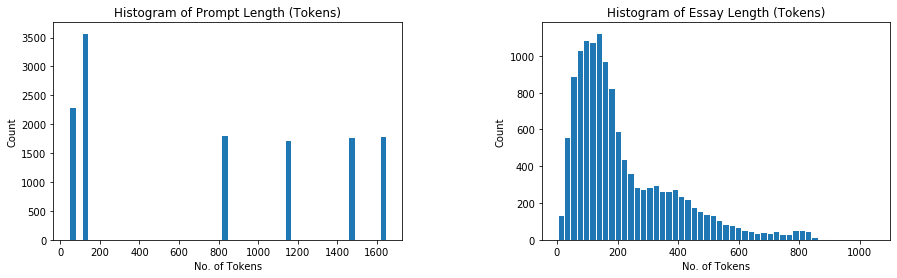

In [0]:
# Plotting histogram for prompt and essay token lengths
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.4)

prompt_len = [len(training_set_rel3_df["tk_prompt"][index]) for index, row in training_set_rel3_df.iterrows()]
essay_len = [len(training_set_rel3_df["tk_essay"][index]) for index, row in training_set_rel3_df.iterrows()]

ax[0].hist(x=prompt_len, bins=50, edgecolor="w")
ax[0].set_title("Histogram of Prompt Length (Tokens)")
ax[0].set_xlabel("No. of Tokens")
ax[0].set_ylabel("Count")

ax[1].hist(x=essay_len, bins=50, edgecolor="w")
ax[1].set_title("Histogram of Essay Length (Tokens)")
ax[1].set_xlabel("No. of Tokens")
ax[1].set_ylabel("Count")

plt.show()

In [0]:
# Setting parameters for max_len
print("Prompt lengths =", set(prompt_len))
max_len_p = 130
print("Setting max_len_p =", max_len_p)
print()

max_len = 650
print("Setting max_len = {}, \n {:.1f}% of essays are shorter than this length."
      .format(max_len, 100*sum(i <= max_len for i in essay_len) / len(training_set_rel3_df)))

Prompt lengths = {1153, 836, 45, 111, 1649, 1460, 58, 127}
Setting max_len_p = 130

Setting max_len = 650, 
 96.8% of essays are shorter than this length.


In [0]:
## NEW VERSION -- with BERT trunking at 512 words

# Padding and trunking for array export
# Padding will be done at the ending for prompts, but trunking will be at the begining for length > max_len_p. 
training_set_rel3_df.insert(loc=7, column="tk_pad_prompt", 
                            value=[row["tk_prompt"][-max_len_p:] if len(row["tk_prompt"])>max_len_p else
                                   row["tk_prompt"] + ["<pad>" for n in range(max_len_p - len(row["tk_prompt"]))]  
                                   if len(row["tk_prompt"])<max_len_p else
                                   row["tk_prompt"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Padding and trunking will be done at the ending for essays. 
training_set_rel3_df.insert(loc=8, column="tk_pad_essay", 
                            value=[row["tk_essay"][:max_len] if len(row["tk_essay"])>max_len else
                                   row["tk_essay"] + ["<pad>" for n in range(max_len - len(row["tk_essay"]))] 
                                   if len(row["tk_essay"])<max_len else
                                   row["tk_essay"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Adding columns for the length of the truncated prompt and the essay to identify no. of words before padding
training_set_rel3_df.insert(loc=9, column="nw_prompt", 
                            value=[len(row["tk_prompt"]) if len(row["tk_prompt"])<max_len_p else
                                   max_len_p
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

training_set_rel3_df.insert(loc=10, column="nw_essay", 
                            value=[len(row["tk_essay"]) if len(row["tk_essay"])<max_len else
                                   max_len
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Adding columns for only truncated prompt and essay, for later BERT embeddings max length is 512
max_len_bert = 512

training_set_rel3_df.insert(loc=11, column="tk_trunc_prompt", 
                            value=[row["tk_prompt"][-max_len_p:] if len(row["tk_prompt"])>max_len_p else
                                   row["tk_prompt"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

training_set_rel3_df.insert(loc=12, column="tk_trunc_essay", 
                            value=[row["tk_essay"][:max_len_bert] if len(row["tk_essay"])>max_len_bert else
                                   row["tk_essay"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Checks for the length of the tokens
assert set([len(training_set_rel3_df["tk_pad_prompt"][index]) 
            for index, row in training_set_rel3_df.iterrows()])==set([max_len_p]), "Checks for Prompt padding fail"
assert set([len(training_set_rel3_df["tk_pad_essay"][index])
            for index, row in training_set_rel3_df.iterrows()])==set([max_len]), "Checks for Essay padding fail"

In [0]:
# Creating train, dev and test sets
train_set, test_set = train_test_split(training_set_rel3_df, test_size=0.1, random_state=0)
train_set, dev_set = train_test_split(train_set, test_size=15/90, random_state=0)

In [0]:
print("No. of examples in Train Set :", len(train_set))
print("No. of examples in Dev Set   :", len(dev_set))
print("No. of examples in Test Set  :", len(test_set))

No. of examples in Train Set : 9732
No. of examples in Dev Set   : 1947
No. of examples in Test Set  : 1298


In [0]:
# Extracting out as arrays, Note: still need to convert to ids based on the embedding
train_set_prompts = np.array(list(train_set["tk_pad_prompt"]))
train_set_essays = np.array(list(train_set["tk_pad_essay"]))
train_set_labels = np.array(list(train_set["scores"]))

dev_set_prompts = np.array(list(dev_set["tk_pad_prompt"]))
dev_set_essays = np.array(list(dev_set["tk_pad_essay"]))
dev_set_labels = np.array(list(dev_set["scores"]))

test_set_prompts = np.array(list(test_set["tk_pad_prompt"]))
test_set_essays = np.array(list(test_set["tk_pad_essay"]))
test_set_labels = np.array(list(test_set["scores"]))

# # Separate extraction for BERT implementation which are only truncated to max length 512, no padding at this stage.
# train_set_prompts_bert = np.array(list(train_set["tk_trunc_prompt"])) 
# train_set_essays_bert = np.array(list(train_set["tk_trunc_essay"]))
# train_set_labels = np.array(list(train_set["scores"]))

# dev_set_prompts_bert = np.array(list(dev_set["tk_trunc_prompt"]))
# dev_set_essays_bert = np.array(list(dev_set["tk_trunc_essay"]))
# dev_set_labels = np.array(list(dev_set["scores"]))

# test_set_prompts_bert = np.array(list(test_set["tk_trunc_prompt"]))
# test_set_essays_bert = np.array(list(test_set["tk_trunc_essay"]))
# test_set_labels = np.array(list(test_set["scores"]))

In [0]:
# Extracting out the no. of words prior to padding just in case
train_set_prompt_nw = np.array(list(train_set["nw_prompt"]))
train_set_essay_nw = np.array(list(train_set["nw_essay"]))

dev_set_prompt_nw = np.array(list(dev_set["nw_prompt"]))
dev_set_essay_nw = np.array(list(dev_set["nw_essay"]))

test_set_prompt_nw = np.array(list(test_set["nw_prompt"]))
test_set_essay_nw = np.array(list(test_set["nw_essay"]))

In [0]:
# Checking the array shape
assert train_set_essays.shape == (len(train_set),max_len), "Checks for array shape fail"

#Checking first 10 tokens of index 0 of train_set_essays
train_set_essays[0][:10]

array(['the', 'mood', 'in', 'the', 'memoir', 'that', 'the', 'author',
       'creates', 'is'], dtype='<U35')

### Baseline

A baseline was established with Neural Bag of Words

![Neural Bag-of-Words Model](neural_bow.png)

Using the following notation:
- $w^{(i)} \in \mathbb{Z}$ for the $i^{th}$ word of the sequence (as an integer index)
- $x^{(i)} \in \mathbb{R}^d$ for the vector representation (embedding) of $w^{(i)}$
- $x \in \mathbb{R}^d$ for the fixed-length vector given by summing all the $x^{(i)}$ for an example
- $h^{(j)}$ for the hidden state after the $j^{th}$ fully-connected layer
- $y$ for the target label ($\in 1,\ldots,\mathtt{num\_classes}$)

Our model is defined as:
- **Embedding layer:** $x^{(i)} = W_{embed}[w^{(i)}]$
- **Summing vectors:** $x = \sum_{i=1}^n x^{(i)}$
- **Hidden layer(s):** $h^{(j)} = f(h^{(j-1)} W^{(j)} + b^{(j)})$ where $h^{(-1)} = x$ and $j = 0,1,\ldots,J-1$
- **Output layer:** $\hat{y} = \hat{P}(y) = \mathrm{softmax}(h^{(final)} W_{out} + b_{out})$ where $h^{(final)} = h^{(J-1)}$ is the output of the last hidden layer.

Logits for the softmax is defined as:
$$ \mathrm{logits} = h^{(final)}W_{out} + b_{out} $$

Other dimensions:
- `V`: the vocabulary size
- `embed_dim`: the embedding dimension $d$
- `hidden_dims`: a list of dimensions for the output of each hidden layer (i.e. $\mathrm{dim}(h^{(j)})$&nbsp;=&nbsp;`hidden_dims[j]`)
- `num_classes`: the number of target classes (2 for the binary task)

In [0]:
# Building the Vocabulary

# Set the threshold number of occurences to prune words from the vocab
prune_threshold = 3

# Defining sorting and unique functions
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(lst):
    return list(uniq(sorted(lst, reverse=False)))

def word_ctr(lst):
    ctr_list = []
    last = object()
    for word in lst:
        if word == last:
            ctr_list[-1] += 1
        else:
            ctr_list.append(1)
        last = word
    return ctr_list

def prune(lst, ctr_lst, num=10):
    assert len(lst) == len(ctr_lst), "List must have same length"
    for i in range(len(lst)):
        if ctr_lst[i] < num and ctr_lst[i] != "<pad>":
            lst[i] = None
    return [w for w in lst if w is not None]

# Add in words from prompts and essays
words = []
for key in tk_prompt_dict.keys():
    words += tk_prompt_dict[key]
for index, row in training_set_rel3_df.iterrows():
    words += [w for w in row["tk_essay"]]

vocab = sort_and_deduplicate(words)
# Pruning words which have less than the threshold occurences
vocab_ctr = word_ctr(sorted(words, reverse=False))
vocab = prune(vocab, vocab_ctr , num=prune_threshold) 
# Pre-load in the words for padding and unknown,
vocab = ["<pad>", "<unk>"] + vocab

# Removing numbers but not <pad> or <unk>
vocab = [w for w in vocab if not any(char.isdigit() for char in w)]

# Checking if there are any "@***" not parsed out
for index, row in training_set_rel3_df.iterrows():
    for w in row["tk_essay"]:
        if '@' in w:
            print("Issues with index", index)
            
# Defining a dictionary for the vocabulary
vocab_dict = {}
for ctr in range(len(vocab)):
    vocab_dict[vocab[ctr]] = ctr

# Defining a get word id function
def get_vocab_id(word):
    if word in vocab_dict.keys():
        return vocab_dict[word]
    else:
        return vocab_dict["<unk>"]
       
# Defining a get word from id function
def get_vocab_word(ids):
    for key, value in vocab_dict.items():
        if ids == value: 
            return key
        else:
            return "<unk>"

# Defining a fuction to convert arrays (train_set_essay / train_set_prompts) into word ids
def get_id_array(arr):
    arr_ids = np.array(list(list(map(get_vocab_id, row)) for row in arr))
    return arr_ids

# Setting the size of the Vocabulary
V = len(vocab_dict)
print("The size of the vocabulary is", V)

The size of the vocabulary is 13382


In [0]:
# Obtaining the word ids for feeding into the model
train_set_prompt_ids = get_id_array(train_set_prompts)
train_set_essay_ids = get_id_array(train_set_essays)

dev_set_prompt_ids = get_id_array(dev_set_prompts)
dev_set_essay_ids = get_id_array(dev_set_essays)

test_set_prompt_ids = get_id_array(test_set_prompts)
test_set_essay_ids = get_id_array(test_set_essays)

In [0]:
# For regression:
num_score_classes = 1
print("No. of class for the classification:", num_score_classes)

No. of class for the classification: 1


In [0]:
tf.reset_default_graph()

In [0]:
# Defining the various layers in the NBOW model

def embedding_layer(ids_, V, embed_dim, init_scale=0.001):
    """Construct an embedding layer.
    Args:
        ids_: [batch_size, max_len] Tensor of int32, integer ids
        V: (int) vocabulary size
        embed_dim: (int) embedding dimension
        init_scale: (float) scale to initialize embeddings

    Returns:
        xs_: [batch_size, max_len, embed_dim] Tensor of float32, embeddings for
            each element in ids_
    """
    ## Assigning variables
    W_embed_ = tf.get_variable('W_embed', shape=[V, embed_dim], dtype=tf.float32,
                          initializer=tf.random_uniform_initializer(-init_scale, init_scale))
    
    ## Looking up embeddings
    xs_ = tf.nn.embedding_lookup(params=W_embed_, ids=ids_)

    return xs_

In [0]:
def fully_connected_layers(h0_, hidden_dims, activation=tf.tanh,
                           dropout_rate=0, is_training=False):
    """Construct a stack of fully-connected layers.

    Args:
        h0_: [batch_size, d] Tensor of float32, the input activations
        hidden_dims: list(int) dimensions of the output of each layer
        activation: TensorFlow function, such as tf.tanh. Passed to
            tf.layers.dense.
        dropout_rate: if > 0, will apply dropout to activations.
        is_training: (bool) if true, is in training mode

    Returns:
        h_: [batch_size, hidden_dims[-1]] Tensor of float32, the activations of
            the last layer constructed by this function.
    """
    h_ = h0_
    for i, hdim in enumerate(hidden_dims):
        h_ = tf.layers.dense(h_, hdim, activation=activation, name=("Hidden_%d"%i))

        if dropout_rate > 0:
            h_ = tf.layers.dropout(h_, rate=dropout_rate, training=is_training) 

    return h_

In [0]:
def mse_output_layer(h_, labels_, num_classes):
    """Construct a mean squared error output layer.

    Implements:
        output = h W + b
        loss = tf.losses.mean_squared_error(labels=labels_, predictions=predictions)

    Args:
        h_: [batch_size, d] Tensor of float32, the input activations from a
            previous layer
        labels_: [batch_size] Tensor of float32, the target label ids
        num_classes: (int) the number of output classes

    Returns: (loss_, predictions_)
    """
    with tf.variable_scope("Predictions"):
        
        ##Assigning variables
        W_out_ = tf.get_variable("W_out", shape=[h_.shape[-1], num_classes], 
                                 dtype=tf.float32,
                                 initializer=tf.random_normal_initializer())
        b_out_ = tf.get_variable("b_out", shape=[num_classes,],
                                 dtype=tf.float32,
                                 initializer=tf.zeros_initializer())
        # Calculating the predictions
        predictions_ = tf.matmul(h_, W_out_) + b_out_
        
    # If no labels provided, don't try to compute loss.
    if labels_ is None:
         return None, predictions_

    with tf.name_scope("MSE"):
        loss_ = tf.losses.mean_squared_error(labels=labels_, predictions=tf.reshape(predictions_, [-1]), weights=1.0)

    return loss_, predictions_

In [0]:
def BOW_encoder(ids_, ns_, V, embed_dim, hidden_dims, dropout_rate=0,
                is_training=None,
                **unused_kw):
    """Construct a bag-of-words encoder.

        - Build the embeddings (using embedding_layer(...))
        - Apply the mask to zero-out padding indices, and sum the embeddings
            for each example
        - Build a stack of hidden layers (using fully_connected_layers(...))

    Args:
        ids_: [batch_size, max_len] Tensor of int32, integer ids
        ns_:  [batch_size] Tensor of int32, (clipped) length of each sequence
        V: (int) vocabulary size
        embed_dim: (int) embedding dimension
        hidden_dims: list(int) dimensions of the output of each layer
        dropout_rate: (float) rate to use for dropout
        is_training: (bool) if true, is in training mode

    Returns: (h_, xs_)
        h_: [batch_size, hidden_dims[-1]] Tensor of float32, the activations of
            the last layer constructed by this function.
        xs_: [batch_size, max_len, embed_dim] Tensor of float32, the per-word
            embeddings as returned by embedding_layer and with the mask applied
            to zero-out the pad indices.
    """
    assert is_training is not None, "is_training must be explicitly set to True or False"
    # Embedding layer:
    #   xs_: [batch_size, max_len, embed_dim]
    with tf.variable_scope("Embedding_Layer"):
         xs_ = embedding_layer(ids_, V, embed_dim, init_scale=0.001)

    # Mask off the padding indices with zeros
    #   mask_: [batch_size, max_len, 1] with values of 0.0 or 1.0
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, xs_.shape[1],
                                           dtype=tf.float32), -1)
    # Multiply xs_ by the mask to zero-out pad indices.
    xs_ = tf.multiply(xs_, mask_)
       
    # Sum embeddings:
    h0_ = tf.math.reduce_sum(xs_, axis=1)
          
    # Fully-connected layers
    h_ = fully_connected_layers(h0_, hidden_dims, activation=tf.tanh,
                                dropout_rate=dropout_rate, is_training=is_training)
    
    return h_, xs_

In [0]:
def regression_model_fn(features, labels, mode, params):
       
    # Check if this graph is going to be used for training.
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    if params['encoder_type'] == 'bow':
        with tf.variable_scope("Encoder"):
            h_, xs_ = BOW_encoder(features['ids'], features['ns'],
                                  is_training=is_training,
                                  **params)
    else:
        raise ValueError("Error: unsupported encoder type "
                         "'{:s}'".format(params['encoder_type']))

    # Construct output mse layer and loss functions
    with tf.variable_scope("Output_Layer"):
        mse_loss_, predictions_ = mse_output_layer(h_, labels, params['num_classes'])

    with tf.name_scope("Prediction"):
        predictions_dict = {"y_hat": predictions_}

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If predict mode, don't bother computing loss.
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions_dict)

    # L2 regularization (weight decay) on parameters, from all layers
    with tf.variable_scope("Regularization"):
        l2_penalty_ = tf.nn.l2_loss(xs_)  # l2 loss on embeddings
        for var_ in tf.trainable_variables():
            if "Embedding_Layer" in var_.name:
                continue
            l2_penalty_ += tf.nn.l2_loss(var_)
        l2_penalty_ *= params['beta']  # scale by regularization strength
        tf.summary.scalar("l2_penalty", l2_penalty_)
        regularized_loss_ = mse_loss_ + l2_penalty_

    with tf.variable_scope("Training"):
        if params['optimizer'] == 'adagrad':
            optimizer_ = tf.train.AdagradOptimizer(params['lr'])
        else:
            optimizer_ = tf.train.GradientDescentOptimizer(params['lr'])
        train_op_ = optimizer_.minimize(regularized_loss_,
                                        global_step=tf.train.get_global_step())
        
    
    tf.summary.scalar("mse_loss", mse_loss_)
    eval_metrics = {"mse_loss": tf.metrics.mean(mse_loss_)}
    
    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions_dict,
                                      loss=regularized_loss_,
                                      train_op=train_op_,
                                      eval_metric_ops=eval_metrics)

In [0]:
# Specify model hyperparameters as used by model_fn
model_params = dict(V=V, embed_dim=100, hidden_dims=[50], num_classes=num_score_classes,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

# Setting the directory to save the checkpoints to
checkpoint_dir = "/tmp/project/tf_baseline_nbow" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

model = tf.estimator.Estimator(model_fn=regression_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)

print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")


To view training (once it starts), run:

    tensorboard --logdir='/tmp/project/tf_baseline_nbow20191130-2339' --port 6006

Then in your browser, open: http://localhost:6006


In [0]:
# Training params for the input_fn to tf.estimator
batch_size = 32
train_params = dict(batch_size=batch_size, total_epochs=20, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Using patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = numpy_input_fn(
                    x={"ids": train_set_essay_ids, "ns": train_set_essay_nw}, y=train_set_labels,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True
                 )

# Input function for dev set batches.
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_set_essay_ids, "ns": dev_set_essay_nw}, y=dev_set_labels,
                    batch_size=batch_size, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")


In [0]:
# Function to calculate Quadratic Weighted Kappa (QWK), from the labels and the predictions
def get_QWK(float_score_list, predict_dict):

    def convert_0_100_scores(float_labels_list):
        return [int(i*100) for i in float_labels_list]

    def convert_prediction_dict_to_lst(predict_dict):
        predict_lst = []
        for d in predict_dict:
            predict_lst.append(d["y_hat"][0])
        return predict_lst
    
    labels_int = convert_0_100_scores(list(float_score_list))
    predict_int = convert_0_100_scores(convert_prediction_dict_to_lst(predict_dict))
    
    return sklearn.metrics.cohen_kappa_score(labels_int, predict_int, weights='quadratic')

In [0]:
predict_dev = list(model.predict(input_fn=dev_input_fn))
print("Neural BOW baseline for MSE on dev set: {:.02%}".format(eval_metrics['mse_loss']))
print("Neural BOW baseline for QWK on dev set: {:.04}".format(get_QWK(dev_set_labels, predict_dev)))

Neural BOW baseline for MSE on dev set: 2.74%
Neural BOW baseline for QWK on dev set: 0.7557


In [0]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_set_essay_ids, "ns": test_set_essay_nw}, y=test_set_labels,
                    batch_size=batch_size, num_epochs=1, shuffle=False
                )

eval_metrics = model.evaluate(input_fn=test_input_fn, name="test")
predict_test = list(model.predict(input_fn=test_input_fn))

print()
print("Neural BOW baseline for MSE on test set: {:.02%}".format(eval_metrics['mse_loss']))
print("Neural BOW baseline for QWK on test set: {:.04}".format(get_QWK(test_set_labels, predict_test)))


Neural BOW baseline for MSE on test set: 2.33%
Neural BOW baseline for QWK on test set: 0.7777


### Baseline Results

Based on running on 7 Apr:    

    Neural BOW baseline for MSE on dev set: 3.83%
    Neural BOW baseline for QWK on dev set: 0.7111
    
    Neural BOW baseline for MSE on test set: 3.53%    
    Neural BOW baseline for QWK on test set: 0.7265

### END